<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some general parameters</a></span></li></ul></li><li><span><a href="#The-example" data-toc-modified-id="The-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The example</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Some general parameters

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 1.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# The example

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 60.4 ms


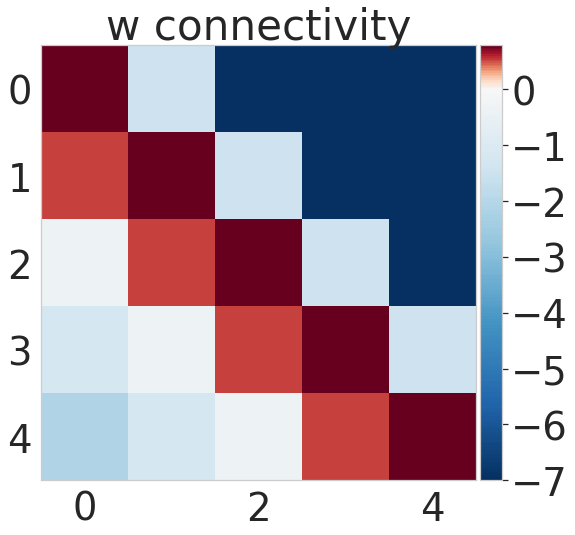

In [3]:
%%time

sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.500
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
plot_weight_matrix(manager)

pattern sequence [0, 1, 2, 3, 4]
times [0.08600000000000001, 0.123, 0.128, 0.128, 0.138]
T_calculated 0.12633333333333333


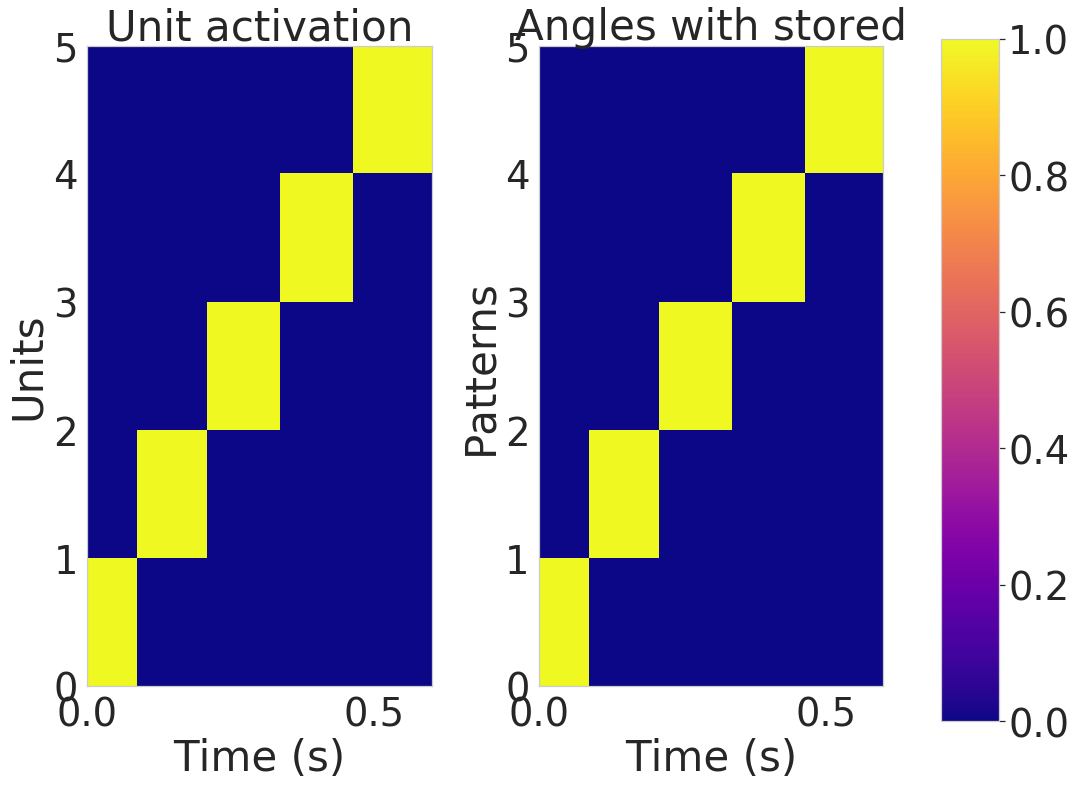

In [4]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 5.0 * manager.nn.tau_s
T_recall = 1.0 * T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

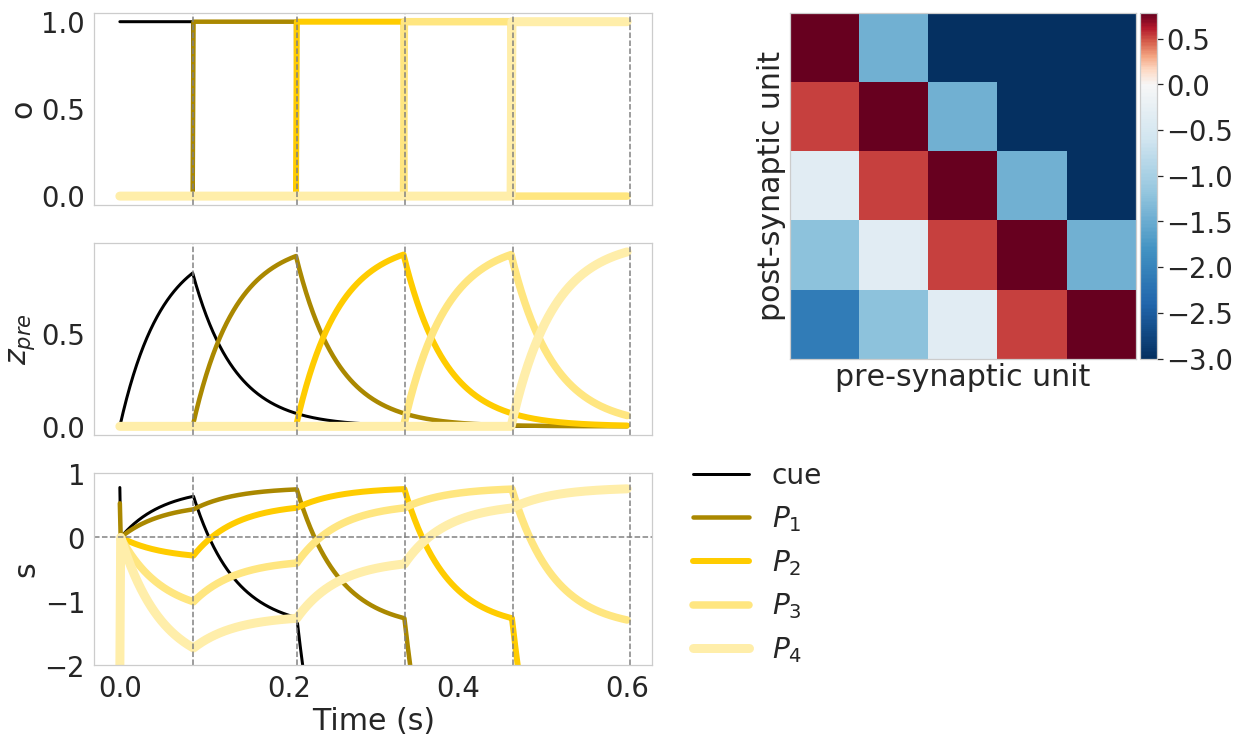

In [5]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']
S = manager.history['s']

sns.set(font_scale=2.5)
sns.set_style("whitegrid", {'axes.grid': False})

colors = ['black', '#aa8800ff', '#ffcc00ff', '#ffe680ff', '#ffeeaaff']
legend = ['cue', r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$']

gs = gridspec.GridSpec(3, 2)
fig = plt.figure(figsize=(22, 12))


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

lw = 1.5
for index in range(n_patterns):
    lw += 1.5
    ax1.plot(manager.time, O[:, index], lw=lw, color=colors[index], label=legend[index])
    ax2.plot(manager.time, Z_pre[:, index], lw=lw, color=colors[index])
    ax3.plot(manager.time, I[:, index], lw=lw, color=colors[index])

ax3.set_ylim([-2.0, 1.0])

ax3.axhline(0, ls='--', color='gray')

ax3.set_xlabel('Time (s)')
ax1.set_ylabel('o')
ax2.set_ylabel(r'$z_{pre}$')
ax3.set_ylabel('s')

ax1.tick_params(axis='x', which='both', labelbottom=False)
ax2.tick_params(axis='x', which='both', labelbottom=False)

aux_t = 0
for T_per in persistent_times:
    aux_t += T_per
    ax1.axvline(aux_t, ls='--', color='gray')
    ax2.axvline(aux_t, ls='--', color='gray')
    ax3.axvline(aux_t, ls='--', color='gray')

# Here we plot our connectivity matrix
rect = [0.48, 0.48, 0.40, 0.40]
# ax_conn = fig.add_subplot(gs[:2, 1])
ax_conn = fig.add_axes(rect)

ax_conn = plot_weight_matrix(manager, ax=ax_conn, vmin=vmin, title=False)
ax_conn.set_xlabel('pre-synaptic unit')
ax_conn.set_ylabel('post-synaptic unit')

ax_conn.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

# Let's plot our legends
# ax_legend = fig.add_subplot(gs[2, 1])
# lines = ax1.get_lines()
handles, labels = ax1.get_legend_handles_labels()
# ax_legend.legend(ax1.get_legend_handles_labels())

fig.legend(handles=handles, labels=labels, loc=(0.55, 0.09), fancybox=True, frameon=False, facecolor=(0.0, 0.0, 0.0),
           fontsize=28, ncol=1)

directory = '../plot_producers/'
file_name = 'basic_example' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

In [6]:
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.015

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.010
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

o_set = timed_input.O.T
z_set = timed_input.z_pre.T
z_set_post = timed_input.z_post.T

In [7]:
cmap = matplotlib.cm.RdBu_r
color_pre_to_post = cmap([0.01, 0.99])[1]
color_post_to_pre = cmap([0.01, 0.99])[0]

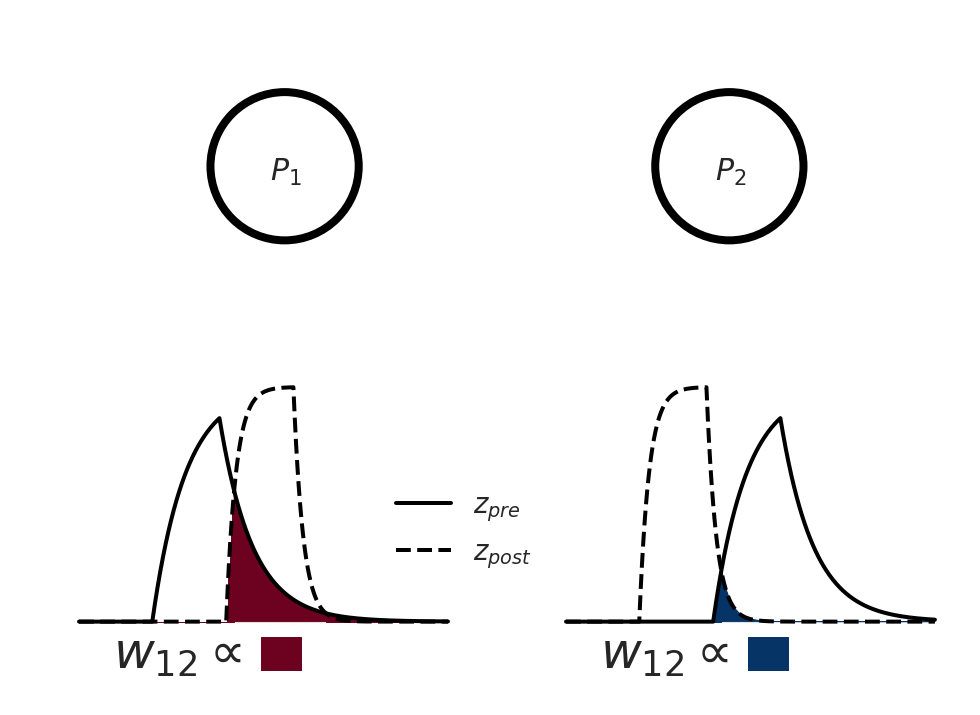

In [14]:
save = True
linewidth = 4
time = np.arange(0, manager.T_training_total, dt)
gs = gridspec.GridSpec(2, 2)



fig = plt.figure(figsize=(16, 12))

ax_diagram = fig.add_subplot(gs[0, :])
# The circles
first_point = -0.25
radius = 0.25
x1 = first_point
x2 = first_point + 6 * radius
y = 0.5
circle1 = plt.Circle((x1, y), radius, lw=8, color='black', alpha=1, fill=False)
circle2 = plt.Circle((x2, y), radius, lw=8, color='black', alpha=1, fill=False)
ax_diagram.add_patch(circle1)
ax_diagram.add_patch(circle2)
off_x = 0.05
ax_diagram.text(x1 -off_x, y - off_x, s=r'$P_1$')
ax_diagram.text(x2 -off_x, y - off_x, s=r'$P_2$')



#ax_diagram.set_xlim([-1, 1])
#ax_diagram.set_ylim([0, 1])
ax_diagram.set_aspect('equal', adjustable='datalim')
### The traces
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# Plot the traces at 1
z_pre = z_set[:, 1]
z_post = z_set_post[:, 2]
ax1.plot(time, z_pre, linewidth=linewidth,  ls='-', color='black', label=r'$z_{pre}$')
ax1.plot(time, z_post, linewidth=linewidth, ls='--', color='black', label=r'$z_{post}$')

# Fill the gap
y1 = z_pre
y2 = z_post
ax1.fill_between(time, y1, 0, where=y1 <= y2 + 0.03, interpolate=True, step='post', 
                 color=color_pre_to_post, hatch='--')
ax1.fill_between(time, y2, 0, where=y2 <= y1, interpolate=True, step='post',
                 color=color_pre_to_post, hatch='--')


# Plot the traces at 2
z_pre = z_set[:, 2]
z_post = z_set_post[:, 1]
ax2.plot(time, z_pre, linewidth=linewidth, ls='-', color='black', label=r'$z_{pre}$')
ax2.plot(time, z_post, linewidth=linewidth, ls='--', color='black', label=r'$z_{post}$')



ax1.legend(frameon=False, loc=(0.8, 0.3))

# Fill the gap
y1 = z_pre
y2 = z_post
ax2.fill_between(time, y1, 0, where=y1 <= y2 , interpolate=True, step='post', color=color_post_to_pre)
ax2.fill_between(time, y2, 0, where=y2 <= y1, interpolate=True, step='post', color=color_post_to_pre)

x_text = 0.05
ax1.text(x_text, -0.2, s=r'$w_{12} \propto$', fontsize=50)
ax2.text(x_text, -0.2, s=r'$w_{12} \propto $', fontsize=50)
ax1.plot([x_text + 0.25], [-0.15], 's', ms=40, color=color_pre_to_post)
ax2.plot([x_text + 0.25], [-0.15], 's', ms=40, color=color_post_to_pre)



if True:
    ax1.axis('off')
    ax2.axis('off')
    ax_diagram.axis('off')
    
if save:
    directory = '../plot_producers/'
    file_name = 'association_diagram' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

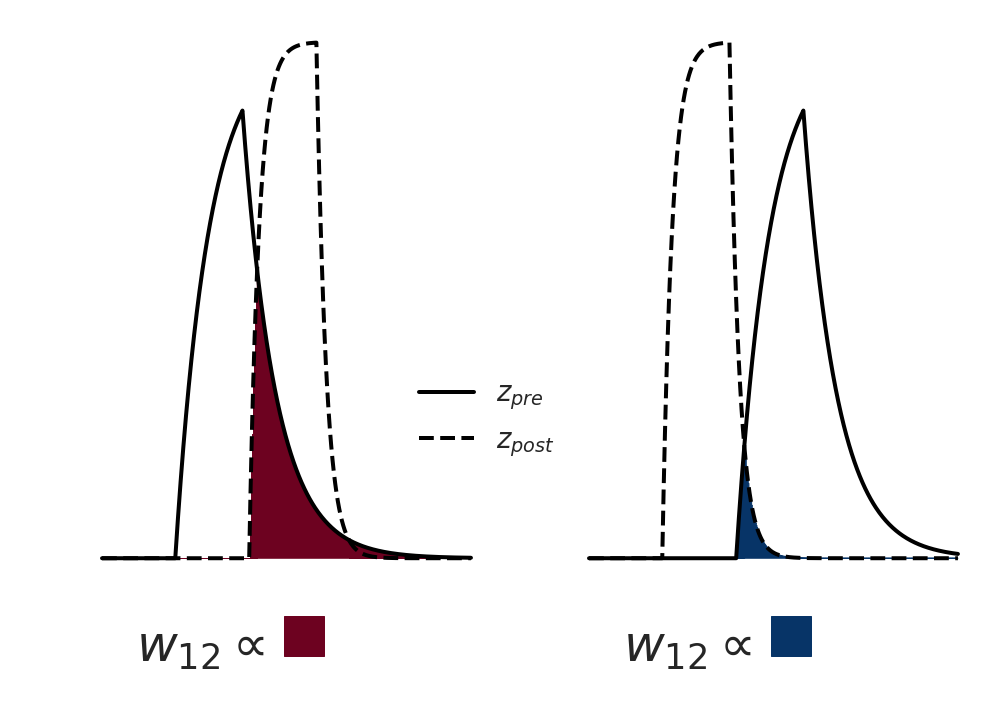

In [15]:
save = True
linewidth = 4
time = np.arange(0, manager.T_training_total, dt)
gs = gridspec.GridSpec(1, 2)



fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Plot the traces at 1
z_pre = z_set[:, 1]
z_post = z_set_post[:, 2]
ax1.plot(time, z_pre, linewidth=linewidth,  ls='-', color='black', label=r'$z_{pre}$')
ax1.plot(time, z_post, linewidth=linewidth, ls='--', color='black', label=r'$z_{post}$')

# Fill the gap
y1 = z_pre
y2 = z_post
ax1.fill_between(time, y1, 0, where=y1 <= y2 + 0.03, interpolate=True, step='post', 
                 color=color_pre_to_post, hatch='--')
ax1.fill_between(time, y2, 0, where=y2 <= y1, interpolate=True, step='post',
                 color=color_pre_to_post, hatch='--')


# Plot the traces at 2
z_pre = z_set[:, 2]
z_post = z_set_post[:, 1]
ax2.plot(time, z_pre, linewidth=linewidth, ls='-', color='black', label=r'$z_{pre}$')
ax2.plot(time, z_post, linewidth=linewidth, ls='--', color='black', label=r'$z_{post}$')



ax1.legend(frameon=False, loc=(0.8, 0.3))

# Fill the gap
y1 = z_pre
y2 = z_post
ax2.fill_between(time, y1, 0, where=y1 <= y2 , interpolate=True, step='post', color=color_post_to_pre)
ax2.fill_between(time, y2, 0, where=y2 <= y1, interpolate=True, step='post', color=color_post_to_pre)

x_text = 0.05
ax1.text(x_text, -0.2, s=r'$w_{12} \propto$', fontsize=50)
ax2.text(x_text, -0.2, s=r'$w_{12} \propto $', fontsize=50)
ax1.plot([x_text + 0.25], [-0.15], 's', ms=40, color=color_pre_to_post)
ax2.plot([x_text + 0.25], [-0.15], 's', ms=40, color=color_post_to_pre)



if True:
    ax1.axis('off')
    ax2.axis('off')
    #ax_diagram.axis('off')
    
if save:
    directory = '../plot_producers/'
    file_name = 'association_diagram' 
    format_string = '.svg'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)